In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import random
from collections import defaultdict
import os
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [2]:
def load_data(file_path):
    if file_path.endswith('.xlsx'):
        df = pd.read_excel(file_path)
    elif file_path.endswith('.csv'):
        df = pd.read_csv(file_path)
    else:
        raise ValueError("Unsupported file format. Please use .xlsx or .csv")

    print(f"Loaded data with {len(df)} transactions")
    print(f"Data columns: {df.columns}")

    G_multi = nx.MultiDiGraph()

    source_col = 'source' if 'source' in df.columns else df.columns[0]
    target_col = 'target' if 'target' in df.columns else df.columns[1]
    weight_col = 'amount' if 'amount' in df.columns else df.columns[2] if len(df.columns) > 2 else None

    unique_nodes = set(df[source_col].unique()) | set(df[target_col].unique())
    G_multi.add_nodes_from(unique_nodes)

    if weight_col and weight_col in df.columns:
        for _, row in df.iterrows():
            G_multi.add_edge(row[source_col], row[target_col], weight=row[weight_col])
    else:
        for _, row in df.iterrows():
            G_multi.add_edge(row[source_col], row[target_col], weight=1.0)

    print(f"Created multi-graph with {G_multi.number_of_nodes()} nodes and {G_multi.number_of_edges()} edges")
    return G_multi

def convert_to_simple_graph(G_multi):
    G = nx.DiGraph()
    G.add_nodes_from(G_multi.nodes())

    edge_weights = defaultdict(float)

    for u, v, data in G_multi.edges(data=True):
        edge_weights[(u, v)] += data.get('weight', 1.0)

    for (u, v), weight in edge_weights.items():
        G.add_edge(u, v, weight=weight)

    print(f"Converted to simple graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
    return G

In [3]:
class Node2Vec:
    def __init__(self, graph, dimensions=128, walk_length=80, num_walks=10, p=1, q=2):
        self.graph = graph
        self.dimensions = dimensions
        self.walk_length = walk_length
        self.num_walks = num_walks
        self.p = p
        self.q = q

        self.precompute_transition_probs()

    def precompute_transition_probs(self):
        self.alias_nodes = {}
        self.alias_edges = {}

        for node in self.graph.nodes():
            neighbors = list(self.graph.successors(node))
            if not neighbors:
                self.alias_nodes[node] = (np.array([]), np.array([]))
                continue

            unnormalized_probs = [self.graph[node][nbr].get('weight', 1.0) for nbr in neighbors]
            if unnormalized_probs:
                norm_const = sum(unnormalized_probs)
                if norm_const > 0:
                    normalized_probs = [float(u_prob)/norm_const for u_prob in unnormalized_probs]
                    self.alias_nodes[node] = self.alias_setup(normalized_probs)
                else:
                    self.alias_nodes[node] = self.alias_setup([1.0/len(neighbors)] * len(neighbors))
            else:
                self.alias_nodes[node] = (np.array([]), np.array([]))

        for edge in self.graph.edges():
            self.alias_edges[edge] = self.get_alias_edge(edge[0], edge[1])

    def get_alias_edge(self, src, dst):
        neighbors = list(self.graph.successors(src))

        if not neighbors:
            return (np.array([]), np.array([]))

        unnormalized_probs = []
        for dst_nbr in neighbors:
            weight = self.graph[src][dst_nbr].get('weight', 1.0)

            if dst_nbr == dst:
                unnormalized_probs.append(weight)
            else:
                if self.graph.has_edge(dst, dst_nbr):
                    if dst_nbr == src:
                        unnormalized_probs.append(weight / self.p)
                    else:
                        unnormalized_probs.append(weight)
                else:
                    unnormalized_probs.append(weight / self.q)

        norm_const = sum(unnormalized_probs)
        if norm_const > 0:
            normalized_probs = [float(u_prob)/norm_const for u_prob in unnormalized_probs]
        else:
            normalized_probs = [1.0/len(neighbors)] * len(neighbors)

        return self.alias_setup(normalized_probs)

    def alias_setup(self, probs):
        K = len(probs)
        if K == 0:
            return np.array([]), np.array([])

        q = np.zeros(K)
        J = np.zeros(K, dtype=np.int32)

        smaller = []
        larger = []

        for kk, prob in enumerate(probs):
            q[kk] = K * prob
            if q[kk] < 1.0:
                smaller.append(kk)
            else:
                larger.append(kk)

        while smaller and larger:
            small = smaller.pop()
            large = larger.pop()

            J[small] = large
            q[large] = q[large] + q[small] - 1.0

            if q[large] < 1.0:
                smaller.append(large)
            else:
                larger.append(large)

        return J, q

    def alias_draw(self, J, q):
        K = len(J)
        if K == 0:
            return None

        kk = int(np.floor(np.random.rand() * K))

        if kk >= K:
            return random.randint(0, K-1) if K > 0 else 0

        if np.random.rand() < q[kk]:
            return int(kk)
        else:
            if int(J[kk]) >= K:
                return random.randint(0, K-1) if K > 0 else 0
            return int(J[kk])

    def node2vec_walk(self, start_node):
        walk = [start_node]

        if not list(self.graph.successors(start_node)):
            return walk

        while len(walk) < self.walk_length:
            cur = walk[-1]
            cur_neighbors = list(self.graph.successors(cur))

            if not cur_neighbors:
                break

            if len(walk) == 1:
                walk.append(random.choice(cur_neighbors))
            else:
                prev = walk[-2]
                edge = (prev, cur)

                if edge in self.alias_edges:
                    J, q = self.alias_edges[edge]
                    if len(J) > 0 and len(cur_neighbors) > 0:
                        idx = self.alias_draw(J, q)
                        if idx is not None and idx < len(cur_neighbors):
                            walk.append(cur_neighbors[idx])
                        else:
                            walk.append(random.choice(cur_neighbors))
                    else:
                        walk.append(random.choice(cur_neighbors))
                else:
                    walk.append(random.choice(cur_neighbors))

        return walk

    def simulate_walks(self):
        walks = []
        nodes = list(self.graph.nodes())

        for _ in range(self.num_walks):
            random.shuffle(nodes)
            for node in nodes:
                walks.append(self.node2vec_walk(node))

        return walks

In [4]:
class SkipGramDataset(Dataset):
    def __init__(self, walks, node_to_idx, window_size=5, num_negative=5):
        self.window_size = window_size
        self.num_negative = num_negative
        self.node_to_idx = node_to_idx
        self.idx_to_node = {idx: node for node, idx in node_to_idx.items()}
        self.node_freq = self._compute_node_frequencies(walks)

        self.pairs = self._generate_training_pairs(walks)
        print(f"Generated {len(self.pairs)} training pairs")

    def _compute_node_frequencies(self, walks):
        freq = defaultdict(int)
        for walk in walks:
            for node in walk:
                freq[self.node_to_idx[node]] += 1
        return freq

    def _generate_training_pairs(self, walks):
        pairs = []

        node_indices = list(range(len(self.node_to_idx)))
        node_prob = np.zeros(len(node_indices))
        total_freq = sum(self.node_freq.values())

        for idx in node_indices:
            node_prob[idx] = self.node_freq.get(idx, 0) ** 0.75 / total_freq

        node_prob = node_prob / node_prob.sum()

        for walk in walks:
            for i, center_node in enumerate(walk):
                center_idx = self.node_to_idx[center_node]

                context_indices = list(range(max(0, i - self.window_size), i)) + \
                                list(range(i + 1, min(len(walk), i + self.window_size + 1)))

                for j in context_indices:
                    context_node = walk[j]
                    context_idx = self.node_to_idx[context_node]

                    pairs.append((center_idx, context_idx, 1))

                    for _ in range(self.num_negative):
                        while True:
                            neg_idx = np.random.choice(node_indices, p=node_prob)
                            if neg_idx != center_idx and neg_idx != context_idx:
                                break

                        pairs.append((center_idx, neg_idx, 0))

        return pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        center_idx, context_idx, is_positive = self.pairs[idx]
        return center_idx, context_idx, is_positive

class SkipGramModel(nn.Module):
    def __init__(self, num_nodes, embedding_dim):
        super(SkipGramModel, self).__init__()

        self.center_embeddings = nn.Embedding(num_nodes, embedding_dim)
        self.context_embeddings = nn.Embedding(num_nodes, embedding_dim)

        self.init_weights()

    def init_weights(self):
        nn.init.xavier_uniform_(self.center_embeddings.weight)
        nn.init.xavier_uniform_(self.context_embeddings.weight)

    def forward(self, center_nodes, context_nodes):
        center_embeds = self.center_embeddings(center_nodes)
        context_embeds = self.context_embeddings(context_nodes)

        scores = torch.sum(center_embeds * context_embeds, dim=1)

        return scores

In [5]:
def train_skip_gram(dataset, embedding_dim, batch_size=128, num_epochs=5, learning_rate=0.01):

    num_nodes = len(dataset.node_to_idx)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Initialize model
    model = SkipGramModel(num_nodes, embedding_dim).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print("Training skip-gram model...")
    for epoch in range(num_epochs):
        total_loss = 0

        for center_nodes, context_nodes, labels in dataloader:
            center_nodes = center_nodes.to(device)
            context_nodes = context_nodes.to(device)
            labels = labels.float().to(device)

            scores = model(center_nodes, context_nodes)

            loss = criterion(scores, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")
    embeddings = model.center_embeddings.weight.detach().cpu().numpy()

    return embeddings, dataset.node_to_idx

In [6]:
def find_optimal_k(embeddings, max_k=10):
    silhouette_scores = []
    k_values = range(2, max_k + 1)

    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(embeddings)

        score = silhouette_score(embeddings, cluster_labels)
        silhouette_scores.append(score)
        print(f"K={k}, Silhouette Score: {score:.4f}")

    plt.figure(figsize=(10, 6))
    plt.plot(k_values, silhouette_scores, 'o-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs. Number of Clusters')
    plt.grid(True)
    plt.savefig('silhouette_scores.png')
    plt.show()
    plt.close()

    best_k = k_values[np.argmax(silhouette_scores)]
    print(f"Best K = {best_k} with silhouette score: {max(silhouette_scores):.4f}")

    inertia_values = []
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(embeddings)
        inertia_values.append(kmeans.inertia_)

    plt.figure(figsize=(10, 6))
    plt.plot(k_values, inertia_values, 'o-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k')
    plt.grid(True)
    plt.savefig('elbow_method.png')
    plt.show()
    plt.close()

    return best_k


In [7]:
def cluster_and_visualize(embeddings, node_to_idx, num_clusters=2):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(embeddings)

    idx_to_node = {idx: node for node, idx in node_to_idx.items()}

    cluster_df = pd.DataFrame({
        'node': [idx_to_node[idx] for idx in range(len(embeddings))],
        'cluster': cluster_labels
    })
    cluster_df.to_csv('node_clusters.csv', index=False)
    print(f"Saved node clustering results to 'node_clusters.csv'")

    pca = PCA(n_components=3)
    embeddings_2d = pca.fit_transform(embeddings)

    plt.figure(figsize=(12, 10))

    colors = plt.cm.rainbow(np.linspace(0, 1, num_clusters))

    for i in range(num_clusters):
        cluster_indices = np.where(cluster_labels == i)[0]

        plt.scatter(
            embeddings_2d[cluster_indices, 0],
            embeddings_2d[cluster_indices, 1],
            c=[colors[i]],
            label=f'Cluster {i}',
            alpha=0.7
        )

    plt.title('2D PCA Visualization of Node Embeddings')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.grid(True)
    plt.savefig('node_embeddings_2d.png')
    plt.show()
    plt.close()


    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    for i in range(num_clusters):
        cluster_indices = np.where(cluster_labels == i)[0]

        ax.scatter(
            embeddings_2d[cluster_indices, 0],
            embeddings_2d[cluster_indices, 1],
            embeddings_2d[cluster_indices, 2] if embeddings_2d.shape[1] > 2 else np.zeros(len(cluster_indices)),
            c=[colors[i]],
            label=f'Cluster {i}',
            alpha=0.7
        )

    ax.set_title('3D PCA Visualization of Node Embeddings')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3' if embeddings_2d.shape[1] > 2 else 'Zeros')
    ax.legend()
    plt.savefig('node_embeddings_3d.png')
    plt.show()
    plt.close()

Starting Node2Vec clustering pipeline...
Loading data from Payments.xlsx...
Loaded data with 130535 transactions
Data columns: Index(['Sender', 'Receiver', 'Amount'], dtype='object')
Created multi-graph with 799 nodes and 130535 edges
Converting multi-graph to simple graph...
Converted to simple graph with 799 nodes and 5358 edges
Applying Node2Vec with p=1, q=2...
Generated 3995 walks of length up to 30
Creating skip-gram dataset...
Generated 2903712 training pairs
Training skip-gram model to learn node embeddings...
Training skip-gram model...
Epoch 1/3, Loss: 0.1876
Epoch 2/3, Loss: 0.1819
Epoch 3/3, Loss: 0.1820
Finding optimal number of clusters...
K=2, Silhouette Score: 0.0954
K=3, Silhouette Score: 0.0896
K=4, Silhouette Score: 0.0719
K=5, Silhouette Score: 0.0732
K=6, Silhouette Score: 0.0629
K=7, Silhouette Score: 0.0529
K=8, Silhouette Score: 0.0493
K=9, Silhouette Score: 0.0447
K=10, Silhouette Score: 0.0573


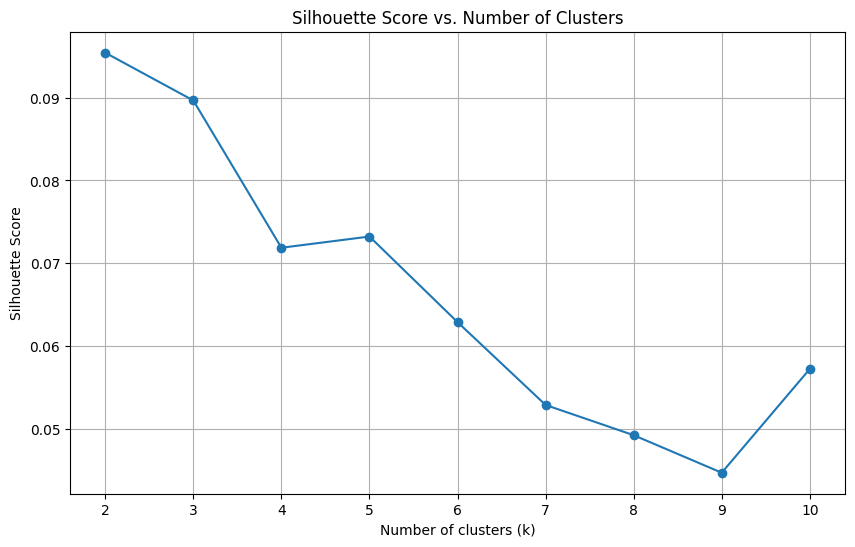

Best K = 2 with silhouette score: 0.0954


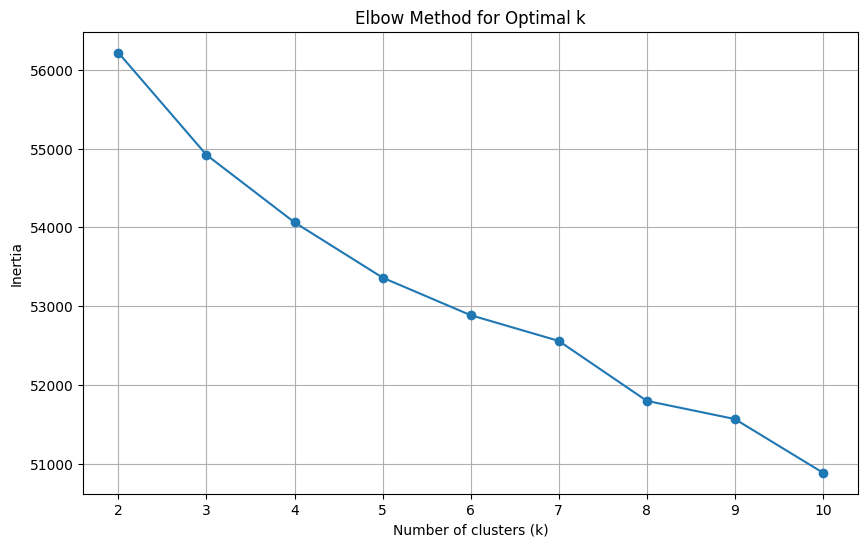

Applying KMeans clustering with k=2...
Saved node clustering results to 'node_clusters.csv'


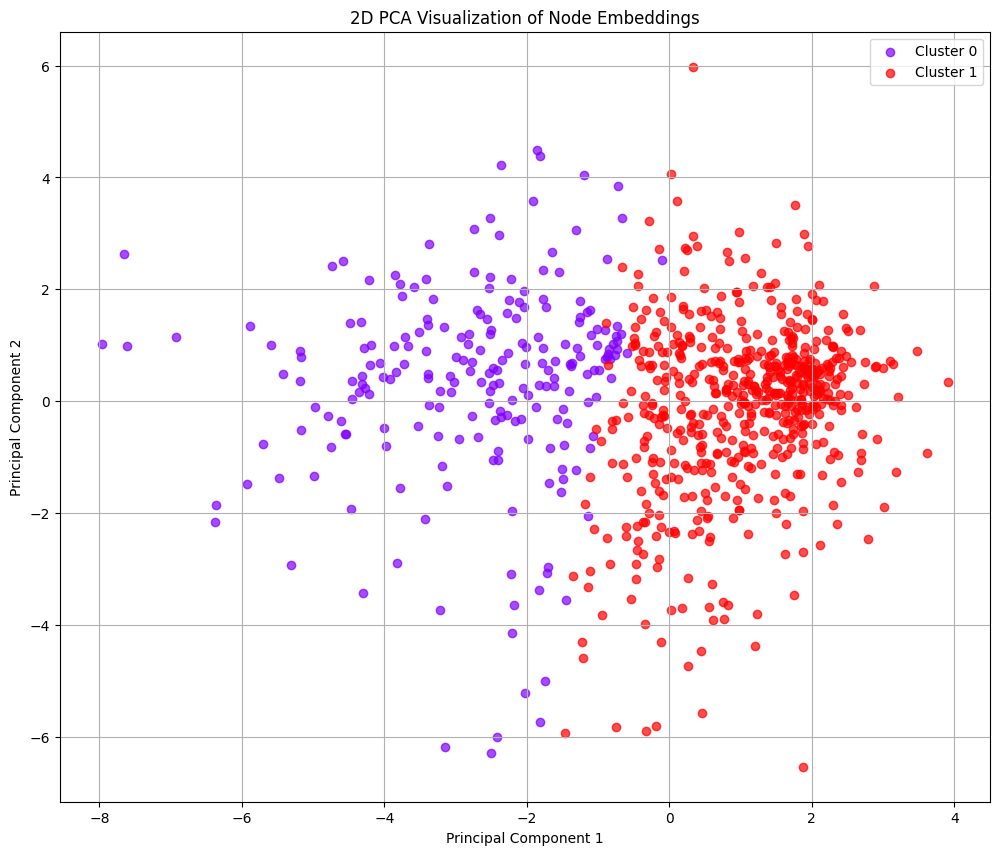

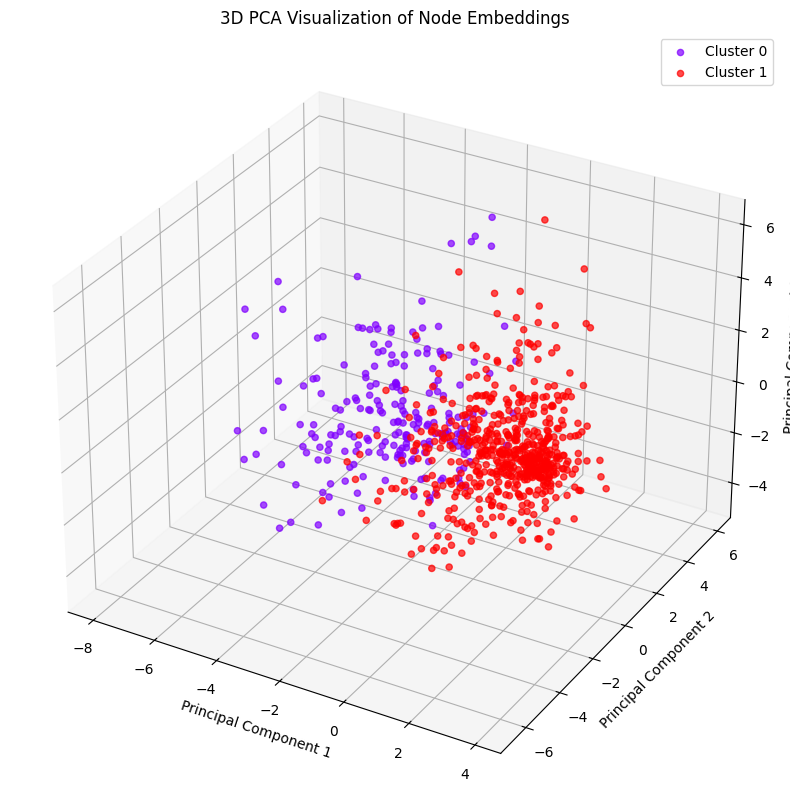

Node2Vec clustering pipeline complete!


In [8]:
def main(file_path, dimensions=128, walk_length=30, num_walks=10, p=1, q=2, window_size=5,
         batch_size=128, num_epochs=5, learning_rate=0.01, find_k=True, num_clusters=2):

    print("Starting Node2Vec clustering pipeline...")

    print(f"Loading data from {file_path}...")
    G_multi = load_data(file_path)

    print("Converting multi-graph to simple graph...")
    G = convert_to_simple_graph(G_multi)

    nodes = list(G.nodes())
    node_to_idx = {node: idx for idx, node in enumerate(nodes)}

    print(f"Applying Node2Vec with p={p}, q={q}...")
    try:
        node2vec = Node2Vec(G, dimensions=dimensions, walk_length=walk_length, num_walks=num_walks, p=p, q=q)
        walks = node2vec.simulate_walks()
        print(f"Generated {len(walks)} walks of length up to {walk_length}")

        print("Creating skip-gram dataset...")
        dataset = SkipGramDataset(walks, node_to_idx, window_size=window_size)

        print("Training skip-gram model to learn node embeddings...")
        embeddings, node_to_idx = train_skip_gram(
            dataset,
            embedding_dim=dimensions,
            batch_size=batch_size,
            num_epochs=num_epochs,
            learning_rate=learning_rate
        )

        if find_k:
            print("Finding optimal number of clusters...")
            best_k = find_optimal_k(embeddings)
            num_clusters = best_k

        print(f"Applying KMeans clustering with k={num_clusters}...")
        cluster_and_visualize(embeddings, node_to_idx, num_clusters=num_clusters)

        print("Node2Vec clustering pipeline complete!")

        return embeddings, node_to_idx

    except Exception as e:
        print(f"Error in Node2Vec processing: {e}")
        raise

if __name__ == "__main__":
    file_name = "Payments"
    if os.path.exists(f"{file_name}.xlsx"):
        file_path = f"{file_name}.xlsx"
    elif os.path.exists(f"{file_name}.csv"):
        file_path = f"{file_name}.csv"
    elif os.path.exists("payments.xlsx"):
        file_path = "payments.xlsx"
    elif os.path.exists("payments.csv"):
        file_path = "payments.csv"
    else:
        print("Error: Could not find payments file. Please ensure 'Payments.xlsx', 'Payments.csv', 'payments.xlsx', or 'payments.csv' exists.")
        exit(1)

    try:
        main(
            file_path=file_path,
            dimensions=64,
            walk_length=30,
            num_walks=5,
            p=1,
            q=2,
            window_size=5,
            batch_size=128,
            num_epochs=3,
            learning_rate=0.01,
            find_k=True,
            num_clusters=2
        )
    except Exception as e:
        print(f"Error running Node2Vec pipeline: {e}")
        print("\nTrying with even more conservative parameters...")

        main(
            file_path=file_path,
            dimensions=32,
            walk_length=10,
            num_walks=3,
            p=1,
            q=1,
            window_size=3,
            batch_size=64,
            num_epochs=2,
            learning_rate=0.01,
            find_k=False,
            num_clusters=2
        )